In [1]:
import os
import pandas as pd
import numpy as np
import copy

from ts_utils import get_seasonal_period
import matplotlib.pyplot as plt

In [2]:
from darts.models import (StatsForecastAutoETS, 
                        StatsForecastAutoARIMA, 
                        StatsForecastAutoTheta)

/Users/biranyucel/miniconda3/envs/darts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from darts.models.forecasting.rnn_model import RNNModel

In [3]:
from darts import TimeSeries
from darts.metrics.metrics import mape, mse

In [4]:
## Steps in general 
# hospital_data = pd.read_csv("datasets/energy/SF_hospital_load.csv")
# data = TimeSeries.from_dataframe(hospital_data, "ds", "y")
# period = get_seasonal_period(data.values())
# test_size = 0.1
# train_size = 1 - test_size
# y_train, y_test = data.split_after(train_size)
# model_copy = copy.deepcopy(StatsForecastAutoTheta(season_length=period))
# model_copy.fit(y_train) 
# horizon = int(data.values().shape[0] * test_size)
# model_copy.predict(horizon)


In [15]:
data_sets = {}
files = ["datasets/energy/SF_hospital_load.csv"]
for file_name in files:
    print(file_name)
    if file_name.lower().endswith('.csv'):
        data_name = file_name.split('/')[-1].split('.csv')[0]
        data = pd.read_csv(file_name)
        if "y" in data.columns:
            data_p = TimeSeries.from_dataframe(data, "ds", "y")
        else:
            data_p = TimeSeries.from_dataframe(data)
        period = get_seasonal_period(data_p.values())
        print(period)
        models = {"AutoTheta": StatsForecastAutoTheta(season_length=period),
                  "AutoARIMA": StatsForecastAutoARIMA(season_length=period),
                  "AutoETS": StatsForecastAutoETS(season_length=period, model="AZZ"),
                 }
        data_sets[data_name] = {'data': data,
                               'processed_data': data_p,
                               'period': period,
                               'models': models}

datasets/energy/SF_hospital_load.csv
24


In [16]:
test_size = 0.1
train_size = 1 - test_size

In [17]:
results = data_sets.copy() # data_sets
for data_name, data in results.items():
    y_train, y_test = data['processed_data'].split_after(train_size)
    results[data_name]['test_size'] = test_size

    for model_name, model in data["models"].items():
        model_copy = copy.deepcopy(model)
        try:
            model_copy.fit(y_train)
            horizon = int(data['processed_data'].values().shape[0] * test_size)
            prediction = model_copy.predict(horizon)
            results[data_name][model_name + "_y_pred"] = prediction
            results[data_name][model_name + "_mape"] = mape(y_test, prediction)
            results[data_name][model_name + "_mse"] = mse(y_test, prediction)
        except:
            results[data_name][model_name + "_y_pred"] = np.nan
            results[data_name][model_name + "_mape"] = np.nan
            results[data_name][model_name + "_mse"] = np.nan
    

In [18]:
res = pd.DataFrame(results)

In [19]:
res[res.index.str.contains("mse")]

,SF_hospital_load
AutoARIMA_mse,16184.110399
AutoETS_mse,51435.757978
AutoTheta_mse,20038.78666


In [20]:
res[res.index.str.contains("mape")]

,SF_hospital_load
AutoARIMA_mape,8.793762
AutoETS_mape,22.203237
AutoTheta_mape,10.498755


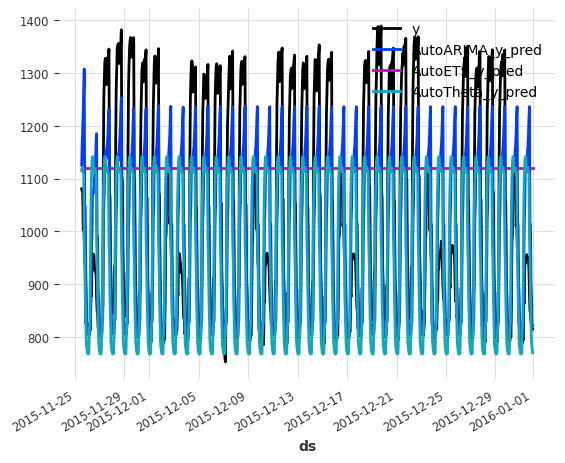

In [21]:
# Only predictions plots
y_train, y_test = res[["SF_hospital_load"]].T["processed_data"][0].split_after(train_size)
y_test.plot(new_plot=True)
preds = res[res.index.str.contains("pred")].to_dict()['SF_hospital_load']
for name, prediction in preds.items():
    prediction.plot(new_plot=False, label=name)

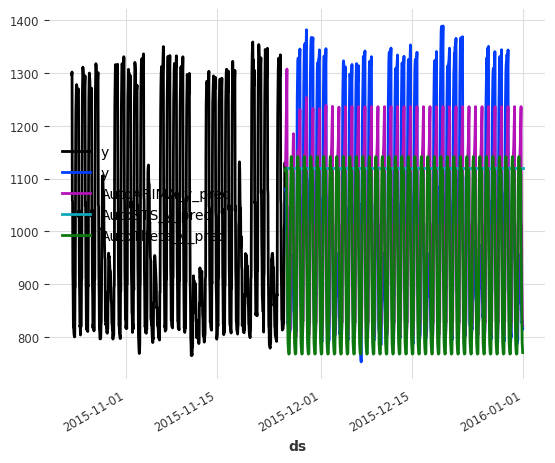

In [22]:
# Plots with training part
y_train, y_test = res[["SF_hospital_load"]].T["processed_data"][0].split_after(train_size)
# Include only the last part of training because of the length of the data
y_train.split_after(0.9)[1].plot(new_plot=True)
y_test.plot(new_plot=False)
preds = res[res.index.str.contains("pred")].to_dict()['SF_hospital_load']
for name, prediction in preds.items():
    prediction.plot(new_plot=False, label=name)